In [14]:
import torch 
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

In [15]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.2])
])


In [16]:
train_path ="FerData/train"
test_path ="FerData/test"
train_dataset=torchvision.datasets.ImageFolder(root=train_path,transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root=test_path,transform=transform)

In [17]:
image , label = train_dataset[30]
image 

tensor([[[-0.0294,  1.0098,  0.8333,  ...,  0.4020,  0.5784,  0.7745],
         [-0.6765,  0.6961,  0.4216,  ...,  0.6569,  0.8333,  1.0882],
         [ 0.5784,  0.7941,  0.3039,  ...,  0.4020,  0.8137,  1.1078],
         ...,
         [-1.6373, -1.6373, -1.5784,  ..., -1.7353, -1.5980, -1.5196],
         [-1.5196, -1.5196, -1.6176,  ..., -1.6569, -1.5980, -1.6765],
         [-1.5588, -1.5784, -1.5588,  ..., -1.6961, -1.6569, -1.6373]]])

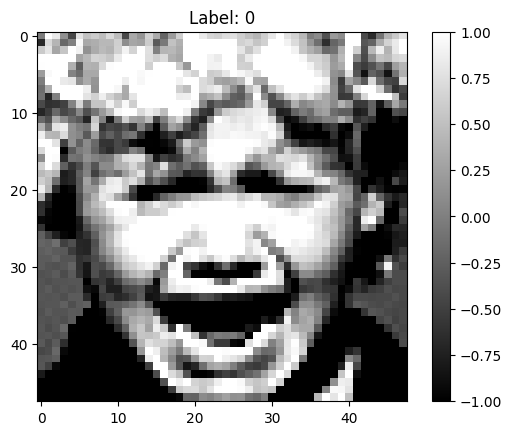

In [18]:
import matplotlib.pyplot as plt 
plt.imshow(image.squeeze(), cmap='gray', vmin=-1, vmax=1)  # Explicitly set scale
plt.title(f"Label: {label}")
plt.colorbar()
plt.show()

In [19]:
batch_size=32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
class FerModel(nn.Module):
    def __init__(self, num_classes=7, dropout=False):
        super(FerModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.5) if dropout else None
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        if self.dropout:
            x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
from torchsummary import summary
model= FerModel().to(device)
print(model)
summary(model,(1,48,48))

FerModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=7, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
------------------------------------------------

In [24]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = train_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, "
              f"Train Acc: {epoch_acc:.4f}")

    return train_losses, train_accuracies

In [25]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")

In [26]:
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 25
train_losses,train_accuracies = train_model(model, train_loader, criterion,optimizer, num_epochs=n_epochs)

Epoch 1/25, Train Loss: 1.5707, Train Acc: 0.3741
Epoch 2/25, Train Loss: 1.2816, Train Acc: 0.5026
Epoch 3/25, Train Loss: 1.1581, Train Acc: 0.5561
Epoch 4/25, Train Loss: 1.0419, Train Acc: 0.6065
Epoch 5/25, Train Loss: 0.9194, Train Acc: 0.6560
Epoch 6/25, Train Loss: 0.7838, Train Acc: 0.7078
Epoch 7/25, Train Loss: 0.6218, Train Acc: 0.7729
Epoch 8/25, Train Loss: 0.4603, Train Acc: 0.8370
Epoch 9/25, Train Loss: 0.3359, Train Acc: 0.8824
Epoch 10/25, Train Loss: 0.2564, Train Acc: 0.9108
Epoch 11/25, Train Loss: 0.1997, Train Acc: 0.9327
Epoch 12/25, Train Loss: 0.1732, Train Acc: 0.9415
Epoch 13/25, Train Loss: 0.1455, Train Acc: 0.9505
Epoch 14/25, Train Loss: 0.1380, Train Acc: 0.9552
Epoch 15/25, Train Loss: 0.1142, Train Acc: 0.9610
Epoch 16/25, Train Loss: 0.1128, Train Acc: 0.9638
Epoch 17/25, Train Loss: 0.1039, Train Acc: 0.9675
Epoch 18/25, Train Loss: 0.0912, Train Acc: 0.9704
Epoch 19/25, Train Loss: 0.0923, Train Acc: 0.9706
Epoch 20/25, Train Loss: 0.0857, Train A

In [27]:
test_model(model, test_loader)

Test Accuracy: 0.6038


In [34]:
from PIL import Image
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
image_path='anger.png'
img = Image.open(image_path)
input_tensor = transform(img).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, 1).item()
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print(f"Predicted emotion: {emotions[pred]}")

Predicted emotion: Surprise


In [32]:
torch.save(model.state_dict(), 'fer_model.pth')